# Image Segmentation with Mask R-CNN (OpenCV library)

In this notebook we will explain step by step how to implement Image Segmentation.   
The goal is to generate a mask for each object in our image, such that we will be able to segment the foreground object from the background.   
Instance segmentation algorithms compute a pixel-wise mask for every detected object in the image.   
We will perform Instance Segmentation using Mask R-CNN architecture as instance segmentation algorithm. The Mask R-CNN algorithm is built upon the Faster R-CNN architecture.  
 

 

## Importing Libraries

First step, we need to import OpenCV, Numpy and Matplotlib libraries.

In [148]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Loading Model Configuration and Pre-trained Weights
We load:
- the Mask R-CNN model weights ("frozen_inference_graph.pb"), which are pre-trained on the COCO dataset, and
- the Mask R-CNN model configuration ("mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

In [149]:
## Loading Mask R-CNN configuration file and pre-trained weights

net = cv2.dnn.readNetFromTensorflow("frozen_inference_graph_coco.pb",                   # weights path
                                    "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")     # config path
                                    
print("MASK R-CNN LOADED SUCCESSFULLY")

MASK R-CNN LOADED SUCCESSFULLY


This is all we need in order to load the model configuration and pre-trained weights.
The next step is to load the image.

## Loading Image

We load and show the image.

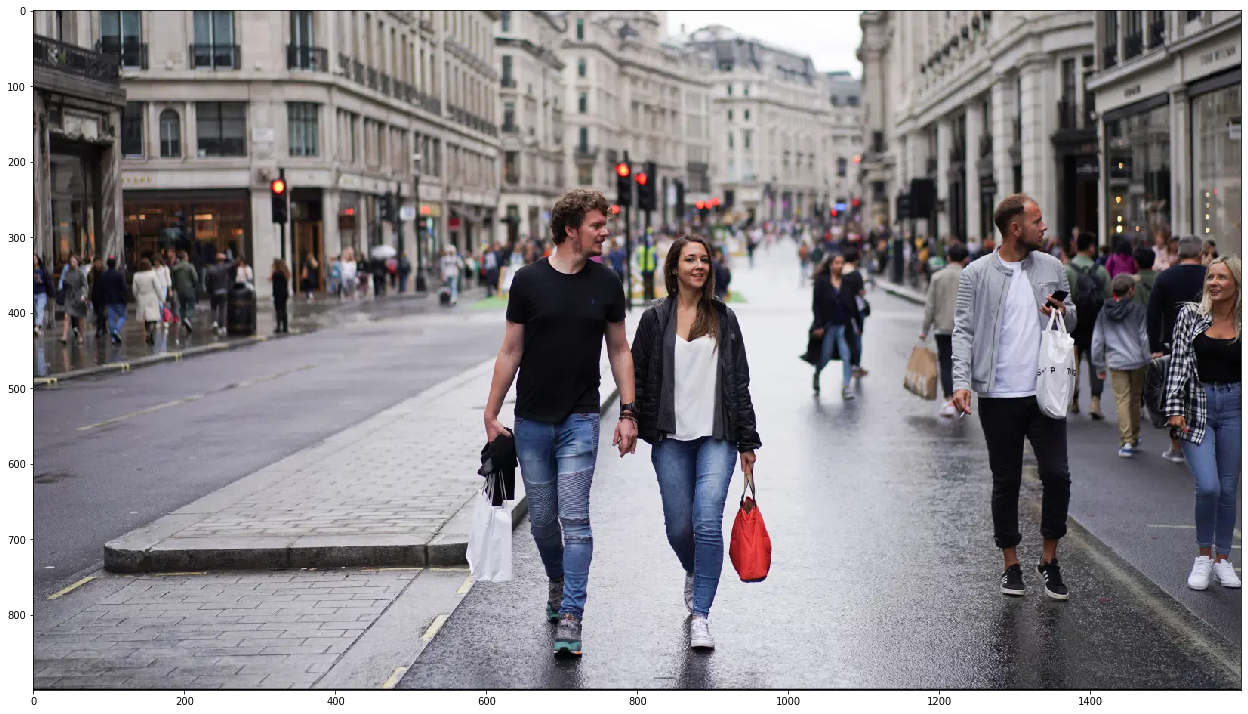

In [150]:
## Loading image  
filename = "segment_img.jpg"           # filename
img = cv2.imread(filename)             # loading image
height, width, _ = img.shape           # retrieve shape from image

## Plot image
dpi = plt.rcParams['figure.dpi']                # let's have a look at the default dpi in jupyter notebook
plt.figure(figsize = (width/dpi, height/dpi))   # to plot the image in the correct shape

img_toplot = img[:,:,::-1]      # cv2 reads the image in GBR. In order to plot, we need to convert to RGB
plt.imshow(img_toplot)
plt.show()

## Image Preprocessing

We can't use the image as input for the model as it is, but we need to convert the image to a blob in order to pass it to the model.

In [151]:
## Using blob function of opencv to preprocess image 
# (The cv2.dnn.blobFromImage function returns a blob which is our input image with color swapping)
blob = cv2.dnn.blobFromImage(img, swapRB=True)  

## Object Detection + Instance Segmentation (network predictions)

We pass the blob as input to the network and then perform a forward pass of the Mask R-CNN, obtaining the following output:
- BOXES - the bounding box  coordinates of the detected objects in the image, with associated class and confidence score,
- MASKS - the pixel-wise segmentation (mask) for each detected object.

In [152]:
net.setInput(blob)                                                     # set blob as input to the network
boxes, masks = net.forward(["detection_out_final", "detection_masks"]) # runs a forward pass to compute the net output 

Let's have a look at the output of the network...

## Network Output 

- <u>BOXES</u>

  We have 100 objects detected in our image.    
  For each of the detected objects, we have an array with 7 elements: 
  2nd element is class id, 3rd element is the confidence score, while remaining elements (4th, 5th, 6th, 7th) are     bounding box coordinates of the detected object.

In [153]:
boxes.shape           # shape of detected boxes

(1, 1, 100, 7)

In [154]:
boxes[0][0][0]        # first object detected in our image

array([0.        , 0.        , 0.9988612 , 0.48908862, 0.33336803,
       0.6041566 , 0.94061065], dtype=float32)

- <u>MASKS</u>

We have a 4D tensor with shape 100 x n_classes x 15 x 15:  
    - 100 are the top 100 detected objects in the image,
    - n_classes is the number of class labels in the dataset (The Mask R-CNN was trained on the COCO dataset, which
      has 90 classes),
    - 15 x 15 is the size of each of the 90 masks.   
      The predicted mask for each object is always 15 x 15 pixels so we will have to resize the mask back to the   
      original input image dimensions later.

In [155]:
masks.shape           # shape of masks tensor

(100, 90, 15, 15)

We can also have a look at the classes in COCO dataset...

## Classes in the COCO dataset

In [178]:
# classes in COCO dataset
classes = ["person","bicycle","car","motorcycle","airplane","bus","train","truck","boat","traffic light",
           "fire hydrant","street sign","stop sign","parking meter","bench","bird","cat","dog","horse",
           "sheep","cow","elephant","bear","zebra","giraffe","hat","backpack","umbrella","shoe","eye glasses",
           "handbag","tie","suitcase","frisbee","skis","snowboard","sports ball","kite","baseball bat",
           "baseball glove","skateboard","surfboard","tennis racket","bottle","plate","wine glass",
           "cup","fork","knife","spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot",
           "hot dog","pizza","donut","cake","chair","couch","potted plant","bed","mirror","dining table",
           "window","desk","toilet","door","tv","laptop","mouse","remote","keyboard","cell phone","microwave",
           "oven","toaster","sink","refrigerator","blender","book","clock","vase","scissors","teddy bear",
           "hair drier","toothbrush"]

print("NUM CLASSES:", len(classes))

NUM CLASSES: 90


## Filtering detections, extracting masks and visualizing Image Segmentation

- We filter out objects detected with a confidence score lower than a specific threshold.
- For the remaining detected objects, we extract the bounding boxes and the associated mask.    
  The predicted mask is only 15 x 15 pixels, so we need to resize the mask back in order to adapt the mask to the size   
  of the object in the original image.
- Finally, we find contours of the masks and we fill the area of the detected objects using a different color for each  
  specific class.   We also create an overlay image in order to obtain transparency in the area of the detected 
  objects.

In [174]:
# random colors to distinguish between different classes (90 classes, 3 channels)
colors = np.random.randint(0, 255, (90, 3))

# make 2 copies of the original image (the first will be the final output, while the second will be the 
# overlay on top)
output = img.copy()             # copy of the original image
overlay = img.copy()            # copy of the original image

In [176]:
num_detections = boxes.shape[2]        # number of detected objects


for i in range(num_detections):        # for each of the detected objects...

    box = boxes[0,0,i]                 # single detected object
    class_id = int(box[1])             # the class associated with the detected object is the second element
    confidence_score = box[2]          # the confidence score for the detected object is the third element

    if confidence_score > 0.5:       # if the confidence score of the detected object is above a specific threshold...
                                     #...we keep on extracting box coordinates and mask associated with that object
            
        label = str(classes[class_id])    # class associated with the object
        print(label, confidence_score)    # print class and confidence score for the detected object

        x1, y1, x2, y2 = box[3:]           # box coordinates  (last 4 elements)

        # we multiply the coordinates for the width and height of our original image
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        object_area = overlay[y1:y2, x1:x2]    # area of the detected object

        object_height, object_width, _ = object_area.shape        # height and width of the detected object

        
        ## MASK ##
        ##########
        
        ## We extract the pixel-wise segmentation (mask) for the detected object, 
        ## we resize the mask such that it's the same dimensions of the bounding box of the detected object
        ## finally, we threshold to create a binary mask.
        
        mask = masks[i, class_id]        # mask associated with the detected object and its predicted class id

        # The predicted mask is only 15 x 15 pixels so we resize the mask back to the original input object dimensions.
        # We need to adapt the mask to the size of the object in the original image
        mask = cv2.resize(mask, (object_width, object_height))

        # For every pixel in the mask, if the pixel value is smaller than the threshold, it is set to 0, 
        # otherwise it is set to a maximum value (255, white pixel). 
        # The function cv2.threshold is used to apply the thresholding and we set a binary thresholding. 
        _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)
     
        mask = np.array(mask, np.uint8)     # convert to array of integer 
        
        # We find the countours of the mask (mask coordinates) 
        # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # We fill the detected object with a specific color for each class. 
        # fillPoly() fills an area bounded by several polygonal contours.
        for cnt in contours:     # for each contour...
            cv2.fillPoly(object_area,            # area to fill
                         [cnt],                  # contours bounding the area
                         (int(colors[class_id][0]), int(colors[class_id][1]), int(colors[class_id][2])) # color
                         )
        
        
# Now, we apply the overlay.
# Overlay is the image that we want to “overlay” on top of the original image using a supplied level 
# of alpha transparency.
alpha = 0.6
cv2.addWeighted(overlay,  # image that we want to “overlay” on top of the original image
                alpha,    # alpha transparency of the overlay (the closer to 0 the more transparent the overlay 
                          # will appear)
                output,   # original source image
                1-alpha,  # beta parameter (1-alpha)
                0,        # gamma value — a scalar added to the weighted sum (we set it to 0)
                output    # our final output image
                )

cv2.imshow("output_img", output)
cv2.imshow("overlay", overlay)
cv2.waitKey(0)
cv2.destroyAllWindows()

person 0.9988612
person 0.99763036
person 0.9974095
person 0.9776986
person 0.9691309
person 0.9637242
person 0.9574097
person 0.9457851
person 0.933185
person 0.88800126
person 0.8871819
handbag 0.88239807
person 0.7784646
traffic light 0.76341325
person 0.758551
person 0.7535921
traffic light 0.72349244
person 0.70074445
person 0.664727
person 0.5748678
person 0.5567503
person 0.5109426
person 0.46653607
person 0.43515068
person 0.4112844
person 0.36658248
person 0.3582434
person 0.35333312
person 0.3474914
person 0.3460069
person 0.33204892
person 0.31983584
handbag 0.30458176


Let's have a look at the final result...

## Image Segmentation result

Finally, we can have a look at the result of Image Segmentation and we can appreciate the shape of the detected objects.   
In the image, we can distinguish 3 classes of detected objects:
 - person,
 - handbag,
 - traffic light.   


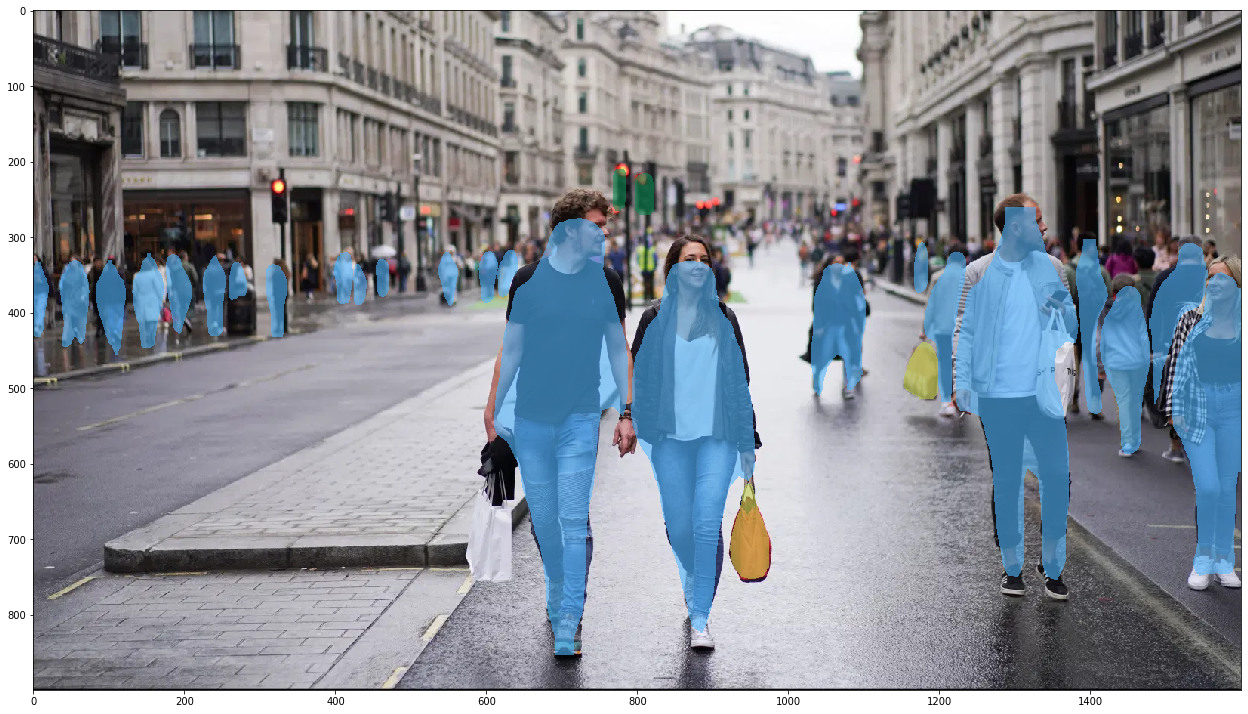

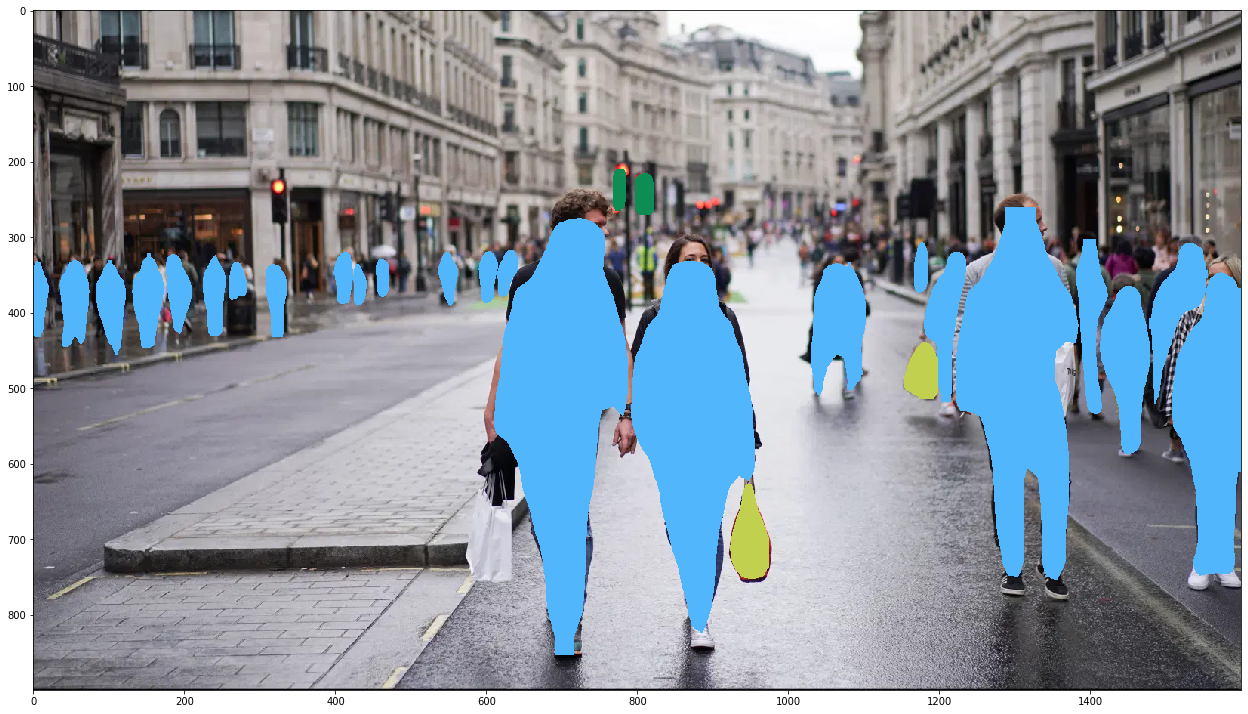

In [133]:
# FINAL IMAGE with Instance Segmentation
plt.figure(figsize = (width/dpi, height/dpi))      # figure size    
segmented_img = output[:,:,::-1]   # convert cv2 image from GBR to RGB (in order to plot it)
plt.imshow(segmented_img)          # show final image with instance segmentation
plt.show()


# OVERLAY image
plt.figure(figsize = (width/dpi, height/dpi))      # figure size  
overlay_img = overlay[:,:,::-1]    # convert cv2 image from GBR to RGB (in order to plot it)
plt.imshow(overlay_img)            # show overlay image with instance segmentation
plt.show()